In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import urllib.parse
import time

print('Libraries imported.')

Libraries imported.


In [10]:
CLIENT_ID = ''        # Foursquare ID
CLIENT_SECRET = ''    # Foursquare Secret
VERSION = '20180605'  # Foursquare API version
LIMIT = 100           # A default Foursquare API limit value

In [5]:
# FourSquare API call 
# Retrieve venues around specified latitude and longitude location
# Returns DF of result
def getNearbyVenues(names, latitudes, longitudes, radius=500, print_progress=True):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        if print_progress:
          print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Return the categories of most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Combines certain venue categories based on mapping
def combine_venue_categories(df, mapping):
  for label, listing in mapping.items():
    df["Venue Category"] = df["Venue Category"].apply(lambda x: label if x in listing else x)
  return df

#Runs KMeans clustering
def run_clustering(df, cluster_count, random_state=None, target='District'):

    df_cip = df.drop(target, 1)
    kmeans = KMeans(n_clusters=cluster_count).fit(df_cip)

    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.show()
    
    return kmeans

# Extracts the top venue categories per region
def venue_extraction(df, num_top_venues = 10, labl = 'District'):
  num_top_venues = 10
  indicators = ['st', 'nd', 'rd']

  # create columns according to number of top venues
  columns = [labl]
  for ind in np.arange(num_top_venues):
      try:
          columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
      except:
          columns.append('{}th Most Common Venue'.format(ind+1))

  # create a new dataframe
  area_venues_sorted = pd.DataFrame(columns=columns)
  area_venues_sorted[labl] = df[labl]

  for ind in np.arange(df.shape[0]):
      area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

  area_venues_sorted.head()
  return area_venues_sorted

# Prints out the clustered results
def show_clusters(df, clusters, limit=10):
  for cluster in range(clusters):
    print("\n\n\nCluster " + str(cluster + 1) + " out of " + str(clusters) + "\n\n")
    display(df.loc[df['Cluster Labels'] == cluster, df.columns[[0] + list(range(limit, df.shape[1]))]])

In [6]:
# Venue Category Merge - Mapping
japanese_restaurants = ['Donburi Restaurant', 'Ramen Restaurant', \
                        'Tonkatsu Restaurant', 'Udon Restaurant', 'Sake Bar', \
                        'Sushi Restaurant', 'Shabu-Shabu Restaurant', \
                        'Japanese Curry Restaurant', 'Yakitori Restaurant', \
                        'Monjayaki Restaurant', 'Yoshoku Restaurant', 'Kushikatsu Restaurant']

asian_restaurant = ['Korean Restaurant', 'Tea Room', 'Vietnamese Restaurant', \
                    'Halal Restaurant', 'Satay Restaurant', 'Malay Restaurant', \
                    'Middle Eastern Restaurant', 'Sri Lankan Restaurant', 'Indian Restaurant']

chinese_restaurant = ['Dim Sum Restaurant', 'Cantonese Restaurant', \
                      'Dumpling Restaurant', 'Szechuan Restaurant',
                      'Taiwanese Restaurant', 'Hainan Restaurant', 'Shanghai Restaurant']

accomodations = ['Hostel', 'Bed & Breakfast', 'Hotel', 'Hotel Pool', \
                 'Residential Building (Apartment / Condo)', 'Resort', 'Motel', \
                 'Boarding House']

western_restaurant = ['American Restaurant', 'German Restaurant', \
                      'Brewery', 'Bistro', 'Pizza Place', 'Steakhouse', \
                      'Breakfast Spot', 'Fried Chicken Joint', \
                      'Mexican Restaurant', 'Spanish Restaurant ', \
                      'Mediterranean Restaurant', 'Wings Joint', 'Burger Joint', \
                      'Italian Restaurant', 'Fast Food Restaurant', \
                      'Eastern European Restaurant', 'Spanish Restaurant', \
                      'French Restaurant', 'Turkish Restaurant', 'Gastropub', \
                      'New American Restaurant', 'Israeli Restaurant', \
                      'Fish & Chips Shop', 'Sandwich Place', 'Deli / Bodega']

nightlife = ['Nightclub', 'Gay Bar', 'Speakeasy', 'Karaoke Bar', 'Jazz Club', \
             'Cocktail Bar', 'Hotel Bar', 'Lounge', 'Wine Bar', \
             'Other Nightlife', 'Beer Bar', 'Massage Studio', 'Spa', 'Bar', \
             'Bath House', 'Irish Pub', 'Beer Garden', 'Whisky Bar', \
             'Wine Shop', 'Pub', 'Night Market', 'Dive Bar']

restaurants = ['Food', 'Diner', 'Snack Place', 'Salad Place', \
               'Comfort Food Restaurant', 'Soup Place', 'Food Court', \
               'Food & Drink Shop', 'Vegetarian / Vegan Restaurant', 'Cafeteria', \
               'Buffet', 'Food Truck', 'Som Tum Restaurant', 'Thai Restaurant', \
               'Food Stand', 'Food Service']

household = ['Organic Grocery', 'Floating Market', 'Auto Garage', 'Laundromat', \
             'Pharmacy', 'Medical Center', 'Health & Beauty Service', \
             'Veterinarian', 'Grocery Store', 'Supermarket', 'Farmers Market', \
             'Grocery', 'Market', 'Flea Market', 'Bakery', 'Bank', 'Butcher', \
             'Salon / Barbershop', 'Dentist\'s Office', 'Nail Salon']

stores = ['Dive Shop', 'Bridal Shop', 'Antique Shop', 'Bike Shop', 'Flower Shop', \
          'Motorcycle Shop', 'Jewelry Store', 'Boutique', 'Shop & Service', \
          'Arts & Crafts Store', 'Hobby Shop', 'Miscellaneous Shop', \
          'Comic Shop', 'Thrift / Vintage Store', 'Herbs & Spices Store', \
          'Men\'s Store', 'Sausage Shop', 'Accessories Store', \
          'Sporting Goods Shop', 'Gourmet Shop', 'Clothing Store', \
          'Cosmetics Shop', 'Mobile Phone Shop', 'Department Store', \
          'Outdoor Supply Store', 'Shoe Store', 'Automotive Shop', \
          'Furniture / Home Store', 'Pet Store', 'Discount Store', 'Video Store', \
          'Electronics Store', 'Big Box Store']

culture = ['Monument / Landmark', 'History Museum', 'Neighborhood', 'Museum', \
           'Historic Site', 'Art Gallery', 'Theater', 'Tour Provider', \
           'Gift Shop', 'Zoo', 'Outdoor Sculpture', 'Concert Hall', \
           'Science Museum', 'Sculpture Garden', 'Performing Arts Venue', \
           'Palace', 'Shrine', 'Buddhist Temple', 'Art Museum', 'Spiritual Center']

activities = ['Movie Theater', 'Garden Center', 'Stadium', 'Park', \
              'Garden', 'Harbor / Marina', 'Bookstore', 'Soccer Stadium', \
              'Music Venue', 'Multiplex', 'Playground', 'Recreation Center', \
              'Bike Rental / Bike Share', 'Dog Run', 'Roof Deck', \
              'Lake', 'Escape Room', 'Theme Park Ride / Attraction', \
              'Cooking School', 'Farm', 'Vineyard', 'Scenic Lookout']

sport = ['Skate Park', 'Golf Driving Range', 'Soccer Field', 'Boxing Gym', \
         'Bowling Alley', 'Sports Club', 'Gym', 'Badminton Court', 'Pool', \
         'Gym / Fitness Center', 'College Gym', 'College Quad', 'Track', \
         'Baseball Field', 'Mini Golf', 'Gun Range', 'Basketball Court', \
         'Tennis Court', 'Squash Court', 'Golf Course', 'Gym Pool', \
         'Athletics & Sports', 'Yoga Studio', 'Dance Studio', 'Skating Rink', \
         'Climbing Gym']

commercial = ['Recording Studio', 'Coworking Space', 'Paper / Office Supplies Store', \
              'Photography Studio', 'Duty-free Shop', 'Other Repair Shop', \
              'Factory', 'Film Studio', 'Auto Workshop', \
              'Auto Dealership', 'Construction & Landscaping', \
              'Office']

infrastructure = ['Train Station', 'Canal', 'Pier', 'Bus Line', 'Building', \
                  'Shopping Mall', 'Pedestrian Plaza', 'Bus Stop', \
                  'Intersection', 'Rest Area', 'Cruise Ship', 'Road', \
                  'Government Building', 'Airport', 'Gas Station', \
                  'Airport Service', 'Airport Lounge', 'Airport Food Court', \
                  'Bus Station', 'River', 'Boat or Ferry', 'Shopping Plaza', 'Library', 'Plaza']

cafe = ['Gaming Cafe', 'Coffee Shop', 'Pet Café']

dessert_shop = ['Bubble Tea Shop', 'Frozen Yogurt Shop', 'Juice Bar', 'Pastry Shop', \
                'Ice Cream Shop', 'Donut Shop', 'Chocolate Shop', 'Creperie', \
                'Dessert Shop', 'Smoothie Shop']

mapping = {'Japanese Restaurant': japanese_restaurants,
           'Asian Restaurant': asian_restaurant,
           'Chinese Restaurant': chinese_restaurant,
           'Accomodation': accomodations, 
           'Western Restaurant': western_restaurant,
           'Nightlife': nightlife,
           'Restaurant': restaurants,
           'Household': household,
           'Culture': culture,
           'Activities': activities,
           'Infrastructure': infrastructure,
           'Commercial': commercial,
           'Café': cafe,
           'Sport': sport,
           'Dessert Shop': dessert_shop,
           'Stores': stores }

In [7]:
# Getting Bangkok's coordinates
address = 'Bangkok'

geolocator = Nominatim(user_agent="bkk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangkok are 13.7544238, 100.4930399.


In [8]:
# Scraping Wikipedia for a list of Bangkok Districts
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok'

df = pd.read_html(url)[0]
html_doc = requests.get(url)
soup = BeautifulSoup(html_doc.text, 'html.parser')

table_contents = []
table = soup.find('table')

for row in table.findAll('tr'):
  cell = {}

  for cnt, text in enumerate(row.findAll('td')):
    if cnt == 0:
      cell['District'] = text.get_text()
    elif cnt == 1:
      cell['Map Number'] = text.get_text()
    elif cnt == 2:
      cell['Postcode'] = text.get_text()
    elif cnt == 3:
      cell['Thai'] = text.get_text()
    elif cnt == 4:
      cell['Population'] = text.get_text()
    elif cnt == 5:
      cell['Subdistrict Count'] = text.get_text()
    elif cnt == 6:
      cell['Latitude'] = text.get_text()
    elif cnt == 7:
      cell['Longitude'] = text.get_text()
      
  if len(cell) != 0:
    table_contents.append(cell)

bkk_districts_wk = pd.DataFrame(table_contents)

bkk_districts_wk['Postcode'] = bkk_districts_wk['Postcode'].str.replace(r'\n', '')
bkk_districts_wk['Population'] = bkk_districts_wk['Population'].str.replace(r',', '')
bkk_districts_wk['Subdistrict Count'] = bkk_districts_wk['Subdistrict Count'].str.replace(r'\n', '')
bkk_districts_wk['Latitude'] = bkk_districts_wk['Latitude'].str.replace(r'\n', '')
bkk_districts_wk['Longitude'] = bkk_districts_wk['Longitude'].str.replace(r'\n', '')
bkk_districts_wk[["Map Number", "Postcode", "Population", "Subdistrict Count", "Latitude", \
    "Longitude"]] = bkk_districts_wk[["Map Number", "Postcode", "Population", \
    "Subdistrict Count", "Latitude", "Longitude"]].apply(pd.to_numeric)
df.head(3)

,District(Khet),MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444


In [11]:
# Tracking the number of categories present from the Foursquare results
#bkk_venues = getNearbyVenues(bkk_districts_wk['District'], bkk_districts_wk['Latitude'], bkk_districts_wk['Longitude'], print_progress=False)
print('There are {} unique categories.'.format(len(bkk_venues['Venue Category'].unique())))

There are 160 unique categories.


In [98]:
bkk_venues.to_csv(r'BKK_Venues.csv', header=True)

In [12]:
# Count and combine the number of Venues
bkk_venue_count = bkk_venues.groupby('District').count()['Venue'].to_frame()
df_bkk = bkk_districts_wk.merge(bkk_venue_count, left_on='District', right_on='District')
df_bkk.rename(columns={'Venue':'Venue Count'}, inplace=True)
df_bkk['Venue Count'] = ( df_bkk['Venue Count'] - df_bkk['Venue Count'].mean()) / df_bkk['Venue Count'].std() # Normalise the number of venues

df_bkk.head(3)

,District,Map Number,Postcode,Thai,Population,Subdistrict Count,Latitude,Longitude,Venue Count
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100,-0.983256
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778,-0.117904
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444,-0.604665


In [168]:
# Plot the map for districts of bangkok based on venue count
map_bangkok = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="Stamen Toner")

for lat, lng, label, count in zip(df_bkk['Latitude'], df_bkk['Longitude'], df_bkk['District'], df_bkk['Venue Count']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= (10 + 5 * count),
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_bangkok)  
map_bangkok

In [13]:
# Combine the venue categories according to the mapping
bkk_venues_condensed = combine_venue_categories(bkk_venues, mapping)
district_venue_category = bkk_venues_condensed.groupby('Venue Category').count()['Venue']
district_venue_category = district_venue_category.sort_values(ascending=False)
district_venue_category.head(10)

Venue Category
Restaurant             152
Café                   130
Noodle House           125
Convenience Store       79
Asian Restaurant        68
Western Restaurant      67
Japanese Restaurant     65
Nightlife               63
Household               55
Dessert Shop            46
Name: Venue, dtype: int64

In [14]:
# Performing One-Hot encoding to explore venue categories
bkk_onehot = pd.get_dummies(bkk_venues_condensed[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
bkk_onehot['District'] = bkk_venues_condensed['District']
# move neighborhood column to the first column
fixed_columns = [bkk_onehot.columns[-1]] + list(bkk_onehot.columns[:-1])
bkk_onehot = bkk_onehot[fixed_columns]

bkk_onehot.head(3)

,District,Accomodation,Activities,Asian Restaurant,BBQ Joint,Café,Chinese Restaurant,Commercial,Convenience Store,Culture,Dessert Shop,Hotpot Restaurant,Household,Infrastructure,Japanese Restaurant,Nightlife,Noodle House,Restaurant,Seafood Restaurant,Shipping Store,Sport,Stores,Western Restaurant,Women's Store
0,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
print(str(bkk_onehot.shape[0]) + " Venues, " + str(bkk_onehot.shape[1]) + " Categories")
bkk_grouped = bkk_onehot.groupby('District').mean().reset_index()
print(str(bkk_grouped.shape[0]) + " Districts")

1159 Venues, 24 Categories
50 Districts


In [17]:
# Extract the most popular venues by District
district_venues_sorted = venue_extraction(bkk_grouped)
district_venues_sorted.head(3)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Restaurant,Japanese Restaurant,Infrastructure,Convenience Store,Women's Store,Dessert Shop,Activities,Asian Restaurant,BBQ Joint,Café
1,Bang Kapi,Noodle House,Japanese Restaurant,Household,Convenience Store,Nightlife,Culture,Stores,Activities,BBQ Joint,Restaurant
2,Bang Khae,Convenience Store,Café,Noodle House,Infrastructure,Stores,BBQ Joint,Western Restaurant,Women's Store,Culture,Activities


# Clustering Bangkok

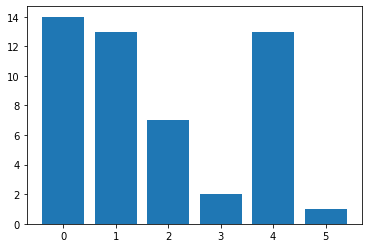

In [21]:
# Run KMeans clustering
bkk_cluster_cnt = 6
district_kmeans = run_clustering(bkk_grouped, bkk_cluster_cnt)

In [22]:
# add clustering labels
if 'Cluster Labels' in district_venues_sorted.columns:
  district_venues_sorted = district_venues_sorted.drop('Cluster Labels', axis=1)

district_venues_sorted.insert(0, 'Cluster Labels', district_kmeans.labels_)

district_clusters = df_bkk
# merge bkk_grouped with bkk data (df) to add latitude/longitude for each neighborhood
district_clusters = district_clusters.join(district_venues_sorted.set_index('District'), on='District')
district_clusters['Cluster Labels'] = district_clusters['Cluster Labels'].replace(np.nan, -1)
district_clusters['Cluster Labels'] = district_clusters['Cluster Labels'].astype(int)
district_clusters.head()

,District,Map Number,Postcode,Thai,Population,Subdistrict Count,Latitude,Longitude,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100,-0.983256,2,Restaurant,Japanese Restaurant,Infrastructure,Convenience Store,Women's Store,Dessert Shop,Activities,Asian Restaurant,BBQ Joint,Café
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778,-0.117904,0,Noodle House,Japanese Restaurant,Household,Convenience Store,Nightlife,Culture,Stores,Activities,BBQ Joint,Restaurant
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444,-0.604665,0,Convenience Store,Café,Noodle House,Infrastructure,Stores,BBQ Joint,Western Restaurant,Women's Store,Culture,Activities
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389,-0.604665,0,Asian Restaurant,Activities,Noodle House,Convenience Store,Stores,Sport,Restaurant,Women's Store,Culture,BBQ Joint
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500,-0.334242,1,Restaurant,Noodle House,Café,Chinese Restaurant,Infrastructure,Household,Asian Restaurant,Western Restaurant,Hotpot Restaurant,Convenience Store


In [23]:
# create map
district_venue_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="Stamen Toner")

# set color scheme for the clusters
x = np.arange(bkk_cluster_cnt)
ys = [i + x + (i*x)**2 for i in range(bkk_cluster_cnt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, count in zip(district_clusters['Latitude'], 
                                         district_clusters['Longitude'], 
                                         district_clusters['District'], 
                                         district_clusters['Cluster Labels'], 
                                         district_clusters['Venue Count']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        popup=label,
        color=rainbow[cluster-1],
        radius= (10 + 5 * count),
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(district_venue_clusters)
       
district_venue_clusters

In [24]:
show_clusters(district_clusters, bkk_cluster_cnt)




Cluster 1 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bang Kapi,Noodle House,Japanese Restaurant,Household,Convenience Store,Nightlife,Culture,Stores,Activities,BBQ Joint,Restaurant
2,Bang Khae,Convenience Store,Café,Noodle House,Infrastructure,Stores,BBQ Joint,Western Restaurant,Women's Store,Culture,Activities
3,Bang Khen,Asian Restaurant,Activities,Noodle House,Convenience Store,Stores,Sport,Restaurant,Women's Store,Culture,BBQ Joint
5,Bang Khun Thian,Japanese Restaurant,Restaurant,Stores,Western Restaurant,Dessert Shop,Household,Sport,Activities,Noodle House,Infrastructure
12,Bueng Kum,Stores,Household,Asian Restaurant,Restaurant,Noodle House,Convenience Store,Dessert Shop,Activities,BBQ Joint,Café
19,Khan Na Yao,Japanese Restaurant,Restaurant,Western Restaurant,Café,Dessert Shop,Household,Activities,BBQ Joint,Nightlife,Asian Restaurant
29,Pathum Wan,Restaurant,Asian Restaurant,Convenience Store,Dessert Shop,Noodle House,Chinese Restaurant,Japanese Restaurant,Seafood Restaurant,Stores,Infrastructure
30,Phasi Charoen,Japanese Restaurant,Western Restaurant,Stores,BBQ Joint,Café,Activities,Hotpot Restaurant,Dessert Shop,Convenience Store,Household
32,Phra Khanong,Convenience Store,Western Restaurant,Accomodation,Dessert Shop,Nightlife,Café,Infrastructure,Japanese Restaurant,Household,Sport
34,Pom Prap Sattru Phai,Noodle House,Chinese Restaurant,Western Restaurant,Café,Restaurant,Convenience Store,Infrastructure,Dessert Shop,Asian Restaurant,Japanese Restaurant





Cluster 2 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bang Kho Laem,Restaurant,Noodle House,Café,Chinese Restaurant,Infrastructure,Household,Asian Restaurant,Western Restaurant,Hotpot Restaurant,Convenience Store
6,Bang Na,Asian Restaurant,Noodle House,Seafood Restaurant,Restaurant,Café,Chinese Restaurant,Infrastructure,Western Restaurant,Women's Store,Culture
8,Bang Rak,Noodle House,Accomodation,Chinese Restaurant,Restaurant,Nightlife,Café,Western Restaurant,Household,Seafood Restaurant,Japanese Restaurant
9,Bang Sue,Restaurant,Noodle House,Café,Convenience Store,Activities,Sport,Seafood Restaurant,Nightlife,Hotpot Restaurant,Women's Store
10,Bangkok Noi,Noodle House,Café,Asian Restaurant,Restaurant,Western Restaurant,Dessert Shop,Activities,Chinese Restaurant,Women's Store,BBQ Joint
11,Bangkok Yai,Noodle House,Household,Asian Restaurant,Restaurant,Café,Dessert Shop,BBQ Joint,Seafood Restaurant,Chinese Restaurant,Infrastructure
17,Dusit,Noodle House,Convenience Store,Dessert Shop,Asian Restaurant,Household,Café,Restaurant,Activities,BBQ Joint,Chinese Restaurant
18,Huai Khwang,Accomodation,Noodle House,Restaurant,Chinese Restaurant,Convenience Store,Hotpot Restaurant,Asian Restaurant,BBQ Joint,Household,Japanese Restaurant
24,Lat Krabang,Restaurant,Asian Restaurant,Noodle House,Accomodation,Dessert Shop,Activities,BBQ Joint,Café,Chinese Restaurant,Commercial
25,Lat Phrao,Restaurant,Café,Noodle House,Asian Restaurant,Household,Convenience Store,Sport,BBQ Joint,Japanese Restaurant,Infrastructure





Cluster 3 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Restaurant,Japanese Restaurant,Infrastructure,Convenience Store,Women's Store,Dessert Shop,Activities,Asian Restaurant,BBQ Joint,Café
15,Din Daeng,Activities,Restaurant,Convenience Store,Accomodation,Sport,Western Restaurant,Dessert Shop,Asian Restaurant,BBQ Joint,Café
16,Don Mueang,Restaurant,Convenience Store,Household,Seafood Restaurant,Nightlife,Accomodation,Shipping Store,Stores,Activities,Asian Restaurant
27,Nong Chok,Restaurant,Household,Dessert Shop,Activities,Asian Restaurant,Commercial,Convenience Store,Infrastructure,BBQ Joint,Café
36,Rat Burana,Restaurant,Sport,Asian Restaurant,Noodle House,Chinese Restaurant,Infrastructure,Western Restaurant,Hotpot Restaurant,Women's Store,Convenience Store
38,Sai Mai,Restaurant,Asian Restaurant,Noodle House,Nightlife,Women's Store,Dessert Shop,Activities,BBQ Joint,Café,Chinese Restaurant
44,Thawi Watthana,Restaurant,Household,Asian Restaurant,Convenience Store,Chinese Restaurant,Nightlife,Infrastructure,Western Restaurant,Culture,Activities





Cluster 4 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Khlong Toei,Nightlife,Restaurant,Commercial,Infrastructure,Women's Store,Dessert Shop,Activities,Asian Restaurant,BBQ Joint,Café
26,Min Buri,Infrastructure,Stores,Restaurant,Nightlife,Women's Store,Culture,Activities,Asian Restaurant,BBQ Joint,Café





Cluster 5 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bang Phlat,Infrastructure,Nightlife,Café,Convenience Store,Household,Western Restaurant,Accomodation,Restaurant,Noodle House,Japanese Restaurant
13,Chatuchak,Café,Restaurant,Household,Nightlife,Accomodation,Sport,Noodle House,Activities,Asian Restaurant,Western Restaurant
14,Chom Thong,Café,Restaurant,Infrastructure,Western Restaurant,Women's Store,Dessert Shop,Activities,Asian Restaurant,BBQ Joint,Chinese Restaurant
20,Khlong Sam Wa,Restaurant,Café,Chinese Restaurant,Nightlife,Japanese Restaurant,Convenience Store,Women's Store,Dessert Shop,Activities,Asian Restaurant
21,Khlong San,Café,Restaurant,Culture,Dessert Shop,Stores,Activities,Nightlife,Chinese Restaurant,Accomodation,Noodle House
23,Lak Si,Café,Western Restaurant,Infrastructure,Restaurant,Household,Japanese Restaurant,Activities,Convenience Store,Dessert Shop,Hotpot Restaurant
28,Nong Khaem,Household,Dessert Shop,Café,Restaurant,Nightlife,Activities,Asian Restaurant,BBQ Joint,Chinese Restaurant,Commercial
31,Phaya Thai,Restaurant,Café,Japanese Restaurant,Nightlife,Western Restaurant,Household,Asian Restaurant,Dessert Shop,Activities,BBQ Joint
33,Phra Nakhon,Nightlife,Accomodation,Asian Restaurant,Restaurant,Café,Culture,Activities,Household,Noodle House,Japanese Restaurant
37,Ratchathewi,Restaurant,Café,Accomodation,Nightlife,Sport,Asian Restaurant,Noodle House,Western Restaurant,Culture,Convenience Store





Cluster 6 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Prawet,Convenience Store,Asian Restaurant,Restaurant,Noodle House,Women's Store,Dessert Shop,Activities,BBQ Joint,Café,Chinese Restaurant


# Getting the list of Subdistricts for Bangkok

In [25]:
# Scrape wikipedia for the list of Subdistricts in Bangkok
url2 = 'https://en.wikipedia.org/wiki/Khwaeng'
bkk_subdistrict_wk = pd.read_html(url2, skiprows=1, header=1)
bkk_subdistrict_wk = bkk_subdistrict_wk[0]
bkk_subdistrict_wk.columns = ['Map Number', 'District', 'District (Thai)', 'Subdistrict Number', 'Subdistrict', 'Subdistrict (Thai)', 'isSeat']
bkk_subdistrict_wk[['Map Number', 'Subdistrict Number']] =  bkk_subdistrict_wk[['Map Number', 'Subdistrict Number']].apply(pd.to_numeric)
bkk_subdistrict_wk['isSeat'] = bkk_subdistrict_wk['isSeat'].apply(lambda x : 0 if pd.isnull(x) else 1)
bkk_subdistrict_wk.head()

,Map Number,District,District (Thai),Subdistrict Number,Subdistrict,Subdistrict (Thai),isSeat
0,1,Phra Nakhon,พระนคร,1,Phra Borom Maha Ratchawang,พระบรมมหาราชวัง,0
1,1,Phra Nakhon,พระนคร,2,Wang Burapha Phirom,วังบูรพาภิรมย์,0
2,1,Phra Nakhon,พระนคร,3,Wat Ratchabophit,วัดราชบพิธ,0
3,1,Phra Nakhon,พระนคร,4,Samran Rat,สำราญราษฎร์,0
4,1,Phra Nakhon,พระนคร,5,San Chaopho Suea,ศาลเจ้าพ่อเสือ,0


# Getting BKK's Subdistrict Coordinates using HERE API

In [26]:
# Load Subdistrict Coordinate information from CSV (obtained using HERE API)
subdistrict_coords = pd.read_csv('BKK_Subdistricts.csv', index_col=0)
subdistrict_coords.head()

,District,Subdistrict,Latitude,Longitude
0,Phra Nakhon,Phra Borom Maha Ratchawang,13.75532,100.49498
1,Phra Nakhon,Wang Burapha Phirom,13.74512,100.49935
2,Phra Nakhon,Wat Ratchabophit,13.75047,100.50029
3,Phra Nakhon,Samran Rat,13.75204,100.50449
4,Phra Nakhon,San Chaopho Suea,13.75467,100.49684


In [78]:
# Merge subdistrict detail with subdistrict coordinates
bkk_subdistricts = bkk_subdistrict_wk.merge(subdistrict_coords, how='left', on=('District', 'Subdistrict')).drop('Map Number', axis=1)
bkk_subdistricts['Subdistrict'] = bkk_subdistricts['Subdistrict'] + ', ' + bkk_subdistricts['District']
bkk_subdistricts = bkk_subdistricts.drop(columns=['District', 'District (Thai)', 'Subdistrict Number', 'Subdistrict (Thai)'], axis=1)
print(bkk_subdistricts.shape)
bkk_subdistricts.head()

(180, 4)


,Subdistrict,isSeat,Latitude,Longitude
0,"Phra Borom Maha Ratchawang, Phra Nakhon",0,13.75532,100.49498
1,"Wang Burapha Phirom, Phra Nakhon",0,13.74512,100.49935
2,"Wat Ratchabophit, Phra Nakhon",0,13.75047,100.50029
3,"Samran Rat, Phra Nakhon",0,13.75204,100.50449
4,"San Chaopho Suea, Phra Nakhon",0,13.75467,100.49684


In [79]:
# Call Foursquare API to extract venue lists by subdistrict coordinates
#bkk_sub_venues = getNearbyVenues(bkk_subdistricts['Subdistrict'], bkk_subdistricts['Latitude'], bkk_subdistricts['Longitude'], print_progress=False)

In [96]:
bkk_sub_venues.to_csv(r'BKK_Subdistrict_Venues.csv', header=True)

In [81]:
print('There are {} unique categories.'.format(len(bkk_sub_venues['Venue Category'].unique())))

bkk_sub_venues.rename(columns={'District':'Subdistrict', 'District Latitude': 'Latitude', 'District Longitude': 'Longitude'}, inplace=True)
bkk_sub_venues.head(3)

There are 257 unique categories.


,Subdistrict,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Phra Borom Maha Ratchawang, Phra Nakhon",13.75532,100.49498,Thokkathan-Mother Earth Squeezing Her Hair (พร...,13.756602,100.494767,Spiritual Center
1,"Phra Borom Maha Ratchawang, Phra Nakhon",13.75532,100.49498,Siwamokhaphiman Hall (พระที่นั่งศิวโมกขพิมาน),13.757516,100.492140,Museum
2,"Phra Borom Maha Ratchawang, Phra Nakhon",13.75532,100.49498,พระที่นั่งพุทไธสวรรย์,13.757895,100.492100,History Museum


In [82]:
bkk_sub_venues['Subdistrict'].nunique()

176

In [83]:
# Count the number of venues by subdistrict
bkk_sub_venue_count = bkk_sub_venues.groupby('Subdistrict').count()['Venue'].to_frame()
df_bkk_sub = bkk_subdistricts.merge(bkk_sub_venue_count, left_on='Subdistrict', right_on='Subdistrict')
df_bkk_sub.rename(columns={'Venue':'Venue Count'}, inplace=True)

# Normalise the venue count
df_bkk_sub['Venue Count'] = ( df_bkk_sub['Venue Count'] - df_bkk_sub['Venue Count'].mean()) / df_bkk_sub['Venue Count'].std()

df_bkk_sub.head(3)

,Subdistrict,isSeat,Latitude,Longitude,Venue Count
0,"Phra Borom Maha Ratchawang, Phra Nakhon",0,13.75532,100.49498,2.037166
1,"Wang Burapha Phirom, Phra Nakhon",0,13.74512,100.49935,0.814094
2,"Wat Ratchabophit, Phra Nakhon",0,13.75047,100.50029,1.176486


In [84]:
# Plot the subdistricts and their venue counts
map_bangkok_subdistricts = folium.Map(location=[latitude, longitude], zoom_start=13, tiles="Stamen Toner")

for lat, lng, label, count in zip(df_bkk_sub['Latitude'], df_bkk_sub['Longitude'], df_bkk_sub['Subdistrict'], df_bkk_sub['Venue Count']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= (5 + 4 * count),
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_bangkok_subdistricts)  

map_bangkok_subdistricts

In [85]:
# Combine the Subdistrict's venue categories based on the mapping
bkk_sub_venues_condensed = combine_venue_categories(bkk_sub_venues, mapping)
subdistrict_venue_category = bkk_sub_venues_condensed.groupby('Venue Category').count()['Venue']
subdistrict_venue_category = subdistrict_venue_category.sort_values(ascending=False)
subdistrict_venue_category.head(20)

Venue Category
Restaurant             555
Café                   428
Noodle House           356
Nightlife              311
Convenience Store      269
Asian Restaurant       234
Western Restaurant     231
Accomodation           203
Household              200
Dessert Shop           144
Japanese Restaurant    143
Chinese Restaurant     139
Sport                  113
Infrastructure         107
Culture                100
Stores                  97
Activities              68
Seafood Restaurant      60
BBQ Joint               50
Hotpot Restaurant       35
Name: Venue, dtype: int64

In [86]:
bkk_sub_onehot = pd.get_dummies(bkk_sub_venues_condensed[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
bkk_sub_onehot['Subdistrict'] = bkk_sub_venues_condensed['Subdistrict']
# move neighborhood column to the first column
fixed_columns = [bkk_sub_onehot.columns[-1]] + list(bkk_sub_onehot.columns[:-1])
bkk_sub_onehot = bkk_sub_onehot[fixed_columns]

bkk_sub_onehot.head(3)

,Subdistrict,Accomodation,Activities,Arcade,Asian Restaurant,BBQ Joint,Business Service,Café,Chinese Restaurant,College Cafeteria,Commercial,Convenience Store,Culture,Cupcake Shop,Dessert Shop,Drugstore,Fishing Spot,Fruit & Vegetable Store,Hotpot Restaurant,Household,Infrastructure,Japanese Restaurant,Kebab Restaurant,Nightlife,Noodle House,Optical Shop,Pawn Shop,Restaurant,Seafood Restaurant,Shipping Store,Sport,Stores,Student Center,Toy / Game Store,Western Restaurant,Women's Store
0,"Phra Borom Maha Ratchawang, Phra Nakhon",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Phra Borom Maha Ratchawang, Phra Nakhon",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Phra Borom Maha Ratchawang, Phra Nakhon",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
print(str(bkk_sub_onehot.shape[0]) + " Venues, " + str(bkk_sub_onehot.shape[1]) + " Categories")

bkk_sub_grouped = bkk_sub_onehot.groupby('Subdistrict').mean().reset_index()
print(str(bkk_sub_grouped.shape[0]) + " Subdistricts")

3877 Venues, 36 Categories
176 Subdistricts


In [88]:
# Group the subdistrict venues and extract the most common venues per subdistrict
subdistrict_venues_sorted = venue_extraction(bkk_sub_grouped, labl='Subdistrict')
subdistrict_venues_sorted.head(3)

,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Anusawari, Bang Khen",Stores,Restaurant,Noodle House,Convenience Store,Chinese Restaurant,Western Restaurant,Asian Restaurant,Household,Infrastructure,Café
1,"Arun Ammarin, Bangkok Noi",Nightlife,Household,Sport,Restaurant,Chinese Restaurant,Women's Store,College Cafeteria,Cupcake Shop,Culture,Convenience Store
2,"Ban Bat, Pom Prap Sattru Phai",Accomodation,Restaurant,Café,Culture,Nightlife,Noodle House,Western Restaurant,Dessert Shop,Chinese Restaurant,Infrastructure


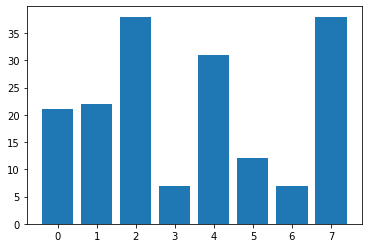

In [90]:
# Perform Subdistrict level clustering
bkk_sub_cluster_cnt = 8
subdistrict_kmeans = run_clustering(bkk_sub_grouped, bkk_sub_cluster_cnt, target='Subdistrict')

In [91]:
# add clustering labels
if 'Cluster Labels' in subdistrict_venues_sorted.columns:  
  subdistrict_venues_sorted = subdistrict_venues_sorted.drop('Cluster Labels', axis=1)

subdistrict_venues_sorted.insert(0, 'Cluster Labels', subdistrict_kmeans.labels_)

df_sub_merged = df_bkk_sub
df_sub_merged.set_index('Subdistrict')
# merge bkk_grouped with bkk data (df) to add latitude/longitude for each neighborhood
df_sub_merged.set_index('Subdistrict').head()
df_sub_merged = df_sub_merged.join(subdistrict_venues_sorted.set_index('Subdistrict'), on='Subdistrict') 
df_sub_merged['Cluster Labels'] = df_sub_merged['Cluster Labels'].replace(np.nan, -1)
df_sub_merged['Cluster Labels'] = df_sub_merged['Cluster Labels'].astype(int)
df_sub_merged.head(3) # check the last columns!

,Subdistrict,isSeat,Latitude,Longitude,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Phra Borom Maha Ratchawang, Phra Nakhon",0,13.75532,100.49498,2.037166,1,Nightlife,Culture,Café,Noodle House,Convenience Store,Dessert Shop,Asian Restaurant,Restaurant,Western Restaurant,Accomodation
1,"Wang Burapha Phirom, Phra Nakhon",0,13.74512,100.49935,0.814094,2,Café,Restaurant,Stores,Asian Restaurant,Household,Noodle House,Western Restaurant,Dessert Shop,Chinese Restaurant,Culture
2,"Wat Ratchabophit, Phra Nakhon",0,13.75047,100.50029,1.176486,2,Restaurant,Café,Noodle House,Dessert Shop,Accomodation,Culture,Household,Western Restaurant,Infrastructure,Activities


In [92]:
# create map
subdistrict_venue_clusters = folium.Map(location=[latitude, longitude], zoom_start=13, tiles="Stamen Toner",)

# set color scheme for the clusters
x = np.arange(bkk_sub_cluster_cnt)
ys = [i + x + (i*x)**2 for i in range(bkk_sub_cluster_cnt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, count in zip(df_sub_merged['Latitude'], 
                                  df_sub_merged['Longitude'], 
                                  df_sub_merged['Subdistrict'], 
                                  df_sub_merged['Cluster Labels'],
                                  df_sub_merged['Venue Count']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius= (6 + 4 * count),
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(subdistrict_venue_clusters)

subdistrict_venue_clusters

In [95]:
show_clusters(df_sub_merged, bkk_sub_cluster_cnt, limit=6)




Cluster 1 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,"Si Yaek Maha Nak, Dusit",Convenience Store,Restaurant,Infrastructure,Accomodation,Noodle House,Culture,Western Restaurant,Household,Pawn Shop,Commercial
16,"Thanon Nakhon Chai Si, Dusit",Café,Sport,Convenience Store,Restaurant,Activities,Chinese Restaurant,College Cafeteria,Dessert Shop,Cupcake Shop,Culture
30,"Hua Mak, Bang Kapi",Café,Asian Restaurant,Sport,Convenience Store,Restaurant,College Cafeteria,Dessert Shop,Cupcake Shop,Culture,Commercial
47,"Lam Pla Thio, Lat Krabang",Convenience Store,Restaurant,Western Restaurant,Stores,Household,Infrastructure,Café,Noodle House,Women's Store,College Cafeteria
65,"Wat Tha Phra, Bangkok Yai",Convenience Store,Chinese Restaurant,Infrastructure,Seafood Restaurant,Café,College Cafeteria,Dessert Shop,Cupcake Shop,Culture,Commercial
77,"Bang Ramat, Taling Chan",Convenience Store,Western Restaurant,Household,Asian Restaurant,Café,Restaurant,Women's Store,Commercial,Dessert Shop,Cupcake Shop
80,"Ban Chang Lo, Bangkok Noi",Convenience Store,Household,Restaurant,Chinese Restaurant,Stores,Sport,BBQ Joint,Noodle House,Women's Store,College Cafeteria
82,"Bang Khun Si, Bangkok Noi",Convenience Store,Restaurant,Household,Chinese Restaurant,Sport,BBQ Joint,Noodle House,Women's Store,College Cafeteria,Cupcake Shop
85,"Samae Dam, Bang Khun Thian",Culture,Convenience Store,Women's Store,College Cafeteria,Drugstore,Dessert Shop,Cupcake Shop,Commercial,Chinese Restaurant,Fruit & Vegetable Store
86,"Bang Wa, Phasi Charoen",Sport,Convenience Store,Café,Restaurant,Western Restaurant,Asian Restaurant,College Cafeteria,Dessert Shop,Cupcake Shop,Culture





Cluster 2 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Phra Borom Maha Ratchawang, Phra Nakhon",Nightlife,Culture,Café,Noodle House,Convenience Store,Dessert Shop,Asian Restaurant,Restaurant,Western Restaurant,Accomodation
4,"San Chaopho Suea, Phra Nakhon",Nightlife,Restaurant,Asian Restaurant,Noodle House,Café,Chinese Restaurant,Dessert Shop,Accomodation,Convenience Store,Western Restaurant
6,"Bowon Niwet, Phra Nakhon",Nightlife,Accomodation,Asian Restaurant,Restaurant,Western Restaurant,Café,Convenience Store,Household,Dessert Shop,Activities
7,"Talat Yot, Phra Nakhon",Nightlife,Restaurant,Asian Restaurant,Accomodation,Café,Culture,Western Restaurant,Household,Noodle House,Convenience Store
8,"Chana Songkhram, Phra Nakhon",Nightlife,Accomodation,Restaurant,Asian Restaurant,Café,Noodle House,Household,Western Restaurant,Convenience Store,Culture
9,"Ban Phan Thom, Phra Nakhon",Accomodation,Nightlife,Culture,Asian Restaurant,Café,Restaurant,Household,Chinese Restaurant,Japanese Restaurant,Noodle House
11,"Wat Sam Phraya, Phra Nakhon",Accomodation,Restaurant,Nightlife,Asian Restaurant,Culture,Household,Activities,Café,Japanese Restaurant,Noodle House
25,"Bang Rak, Bang Rak",Restaurant,Accomodation,Chinese Restaurant,Western Restaurant,Nightlife,Café,Sport,Asian Restaurant,Household,BBQ Joint
26,"Si Phraya, Bang Rak",Restaurant,Accomodation,Nightlife,Café,Asian Restaurant,Convenience Store,Culture,Western Restaurant,Seafood Restaurant,Sport
31,"Rong Mueang, Pathum Wan",Restaurant,Accomodation,Chinese Restaurant,Convenience Store,Dessert Shop,Nightlife,Noodle House,Activities,Western Restaurant,Infrastructure





Cluster 3 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Wang Burapha Phirom, Phra Nakhon",Café,Restaurant,Stores,Asian Restaurant,Household,Noodle House,Western Restaurant,Dessert Shop,Chinese Restaurant,Culture
2,"Wat Ratchabophit, Phra Nakhon",Restaurant,Café,Noodle House,Dessert Shop,Accomodation,Culture,Household,Western Restaurant,Infrastructure,Activities
5,"Sao Chingcha, Phra Nakhon",Restaurant,Dessert Shop,Café,Noodle House,Household,Asian Restaurant,Culture,Convenience Store,Nightlife,Western Restaurant
17,"Nong Chok, Nong Chok",Chinese Restaurant,Household,Restaurant,College Cafeteria,Dessert Shop,Cupcake Shop,Culture,Convenience Store,Commercial,Women's Store
19,"Khu Fang Nuea, Nong Chok",Household,Stores,Asian Restaurant,Restaurant,Women's Store,College Cafeteria,Dessert Shop,Cupcake Shop,Culture,Convenience Store
29,"Khlong Chan, Bang Kapi",Restaurant,Noodle House,Activities,Western Restaurant,Infrastructure,Japanese Restaurant,Women's Store,Cupcake Shop,Culture,Convenience Store
45,"Khlong Song Ton Nun, Lat Krabang",Restaurant,Western Restaurant,Household,Nightlife,Women's Store,College Cafeteria,Cupcake Shop,Culture,Convenience Store,Commercial
55,"Sam Sen Nai, Phaya Thai",Restaurant,Café,Western Restaurant,Activities,Commercial,Drugstore,Dessert Shop,Cupcake Shop,Culture,Convenience Store
56,"Phaya Thai, Phaya Thai",Restaurant,Café,Japanese Restaurant,Household,Accomodation,Asian Restaurant,Seafood Restaurant,Nightlife,Western Restaurant,Infrastructure
68,"Sam Sen Nok, Huai Khwang",Noodle House,Household,Restaurant,Convenience Store,Café,Western Restaurant,Kebab Restaurant,Nightlife,Women's Store,Culture





Cluster 4 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"Lam Phak Chi, Nong Chok",Restaurant,Western Restaurant,College Cafeteria,Drugstore,Dessert Shop,Cupcake Shop,Culture,Convenience Store,Commercial,Women's Store
21,"Lam Toiting, Nong Chok",Restaurant,Women's Store,College Cafeteria,Drugstore,Dessert Shop,Cupcake Shop,Culture,Convenience Store,Commercial,Chinese Restaurant
28,"Tha Raeng, Bang Khen",Restaurant,Household,Convenience Store,Noodle House,Women's Store,College Cafeteria,Dessert Shop,Cupcake Shop,Culture,Commercial
40,"Bang Chak, Phra Khanong",Restaurant,Convenience Store,Women's Store,College Cafeteria,Drugstore,Dessert Shop,Cupcake Shop,Culture,Commercial,Chinese Restaurant
46,"Khlong Sam Prawet, Lat Krabang",Restaurant,Women's Store,College Cafeteria,Drugstore,Dessert Shop,Cupcake Shop,Culture,Convenience Store,Commercial,Chinese Restaurant
125,"Suan Luang, Suan Luang",Restaurant,Women's Store,College Cafeteria,Drugstore,Dessert Shop,Cupcake Shop,Culture,Convenience Store,Commercial,Chinese Restaurant
164,"Sai Kong Din, Khlong Sam Wa",Restaurant,Noodle House,Women's Store,College Cafeteria,Dessert Shop,Cupcake Shop,Culture,Convenience Store,Commercial,Chinese Restaurant





Cluster 5 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"Si Lom, Bang Rak",Café,Japanese Restaurant,Restaurant,Western Restaurant,Accomodation,Nightlife,Asian Restaurant,BBQ Joint,Stores,Dessert Shop
24,"Suriyawong, Bang Rak",Japanese Restaurant,Café,Restaurant,Western Restaurant,Chinese Restaurant,Accomodation,Asian Restaurant,BBQ Joint,Nightlife,Stores
33,"Pathum Wan, Pathum Wan",Sport,Nightlife,Western Restaurant,Infrastructure,Japanese Restaurant,Restaurant,Café,Women's Store,Culture,Convenience Store
34,"Lumphini, Pathum Wan",Nightlife,Sport,Restaurant,Café,Western Restaurant,Japanese Restaurant,Accomodation,Activities,Infrastructure,Asian Restaurant
41,"Phra Khanong Tai, Phra Khanong",Café,Western Restaurant,Japanese Restaurant,Convenience Store,Household,Culture,Restaurant,Infrastructure,Nightlife,Sport
44,"Lat Krabang, Lat Krabang",Infrastructure,Nightlife,Household,Seafood Restaurant,Restaurant,Café,Commercial,Women's Store,Cupcake Shop,Culture
50,"Chong Nonsi, Yan Nawa",Café,Stores,Restaurant,Western Restaurant,Culture,Commercial,Nightlife,College Cafeteria,Cupcake Shop,Convenience Store
51,"Bang Phongphang, Yan Nawa",Café,Sport,Culture,Restaurant,Chinese Restaurant,Dessert Shop,Cupcake Shop,Convenience Store,Commercial,College Cafeteria
57,"Wat Kanlaya, Thon Buri",Convenience Store,Restaurant,Western Restaurant,Nightlife,Café,Noodle House,Household,Infrastructure,Culture,Activities
63,"Samre, Thon Buri",Café,Japanese Restaurant,Western Restaurant,Accomodation,Noodle House,Chinese Restaurant,Infrastructure,Restaurant,Nightlife,Asian Restaurant





Cluster 6 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Dusit, Dusit",Noodle House,Café,Convenience Store,Restaurant,Dessert Shop,Asian Restaurant,Sport,Chinese Restaurant,Household,BBQ Joint
18,"Khlong Sip, Nong Chok",Noodle House,Women's Store,Fruit & Vegetable Store,Drugstore,Dessert Shop,Cupcake Shop,Culture,Convenience Store,Commercial,College Cafeteria
36,"Wat Thep Sirin, Pom Prap Sattru Phai",Noodle House,Asian Restaurant,Convenience Store,Culture,Japanese Restaurant,Café,Chinese Restaurant,Nightlife,Women's Store,Dessert Shop
42,"Min Buri, Min Buri",Noodle House,Dessert Shop,Sport,Women's Store,College Cafeteria,Cupcake Shop,Culture,Convenience Store,Commercial,Chinese Restaurant
43,"Saen Saep, Min Buri",Noodle House,Western Restaurant,Convenience Store,Fishing Spot,Drugstore,Dessert Shop,Cupcake Shop,Culture,Commercial,Women's Store
59,"Bang Yi Ruea, Thon Buri",Noodle House,Asian Restaurant,BBQ Joint,Shipping Store,Household,Restaurant,Infrastructure,Women's Store,Commercial,Cupcake Shop
61,"Talat Phlu, Thon Buri",Noodle House,Café,Stores,Sport,BBQ Joint,Restaurant,Women's Store,College Cafeteria,Cupcake Shop,Culture
81,"Bang Khun Non, Bangkok Noi",Noodle House,Restaurant,Western Restaurant,Asian Restaurant,Café,Activities,Dessert Shop,Women's Store,Commercial,Cupcake Shop
106,"Thung Wat Don, Sathon",Noodle House,Restaurant,Western Restaurant,Asian Restaurant,Café,Dessert Shop,Sport,Seafood Restaurant,Hotpot Restaurant,Nightlife
112,"Sena Nikhom, Chatuchak",Noodle House,Asian Restaurant,Household,Restaurant,Chinese Restaurant,Commercial,Arcade,Sport,Western Restaurant,Café





Cluster 7 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,"Thap Yao, Lat Krabang",Household,Stores,Infrastructure,Convenience Store,Women's Store,College Cafeteria,Dessert Shop,Cupcake Shop,Culture,Commercial
49,"Khum Thong, Lat Krabang",Household,Convenience Store,Infrastructure,Women's Store,Fishing Spot,Dessert Shop,Cupcake Shop,Culture,Commercial,College Cafeteria
67,"Bang Kapi, Huai Khwang",Convenience Store,Western Restaurant,Household,Stores,Hotpot Restaurant,Café,Infrastructure,Nightlife,Dessert Shop,Activities
84,"Tha Kham, Bang Khun Thian",Household,Café,Convenience Store,Women's Store,Commercial,Drugstore,Dessert Shop,Cupcake Shop,Culture,College Cafeteria
97,"Bang Phlat, Bang Phlat",Convenience Store,Noodle House,Household,Women's Store,Fishing Spot,Dessert Shop,Cupcake Shop,Culture,Commercial,College Cafeteria
130,"Bang Mot, Chom Thong",Household,Convenience Store,Activities,Infrastructure,Japanese Restaurant,Café,Restaurant,Women's Store,Commercial,Cupcake Shop
171,"Thung Khru, Thung Khru",Household,Café,Activities,Sport,Convenience Store,Women's Store,Commercial,Dessert Shop,Cupcake Shop,Culture





Cluster 8 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Samran Rat, Phra Nakhon",Noodle House,Restaurant,Accomodation,Culture,Café,Dessert Shop,Asian Restaurant,Household,Nightlife,Infrastructure
10,"Bang Khun Phrom, Phra Nakhon",Noodle House,Café,Asian Restaurant,Restaurant,Accomodation,Convenience Store,Chinese Restaurant,Culture,Household,Dessert Shop
13,"Wachiraphayaban, Dusit",Restaurant,Noodle House,Café,Accomodation,Asian Restaurant,Culture,Household,Infrastructure,Convenience Store,Western Restaurant
14,"Suan Chitlada, Dusit",Café,Culture,Noodle House,Restaurant,Convenience Store,Hotpot Restaurant,Infrastructure,College Cafeteria,Dessert Shop,Fruit & Vegetable Store
22,"Maha Phruettharam, Bang Rak",Noodle House,Accomodation,Restaurant,Chinese Restaurant,Asian Restaurant,Dessert Shop,Convenience Store,Western Restaurant,Nightlife,Seafood Restaurant
27,"Anusawari, Bang Khen",Stores,Restaurant,Noodle House,Convenience Store,Chinese Restaurant,Western Restaurant,Asian Restaurant,Household,Infrastructure,Café
32,"Wang Mai, Pathum Wan",Accomodation,Dessert Shop,Asian Restaurant,Café,Nightlife,Convenience Store,Activities,Japanese Restaurant,Restaurant,Western Restaurant
35,"Pom Prap, Pom Prap Sattru Phai",Noodle House,Chinese Restaurant,Café,Asian Restaurant,Dessert Shop,Nightlife,Seafood Restaurant,Restaurant,Culture,Household
37,"Khlong Maha Nak, Pom Prap Sattru Phai",Noodle House,Convenience Store,Asian Restaurant,Culture,Restaurant,Hotpot Restaurant,Western Restaurant,Household,Japanese Restaurant,Dessert Shop
39,"Wat Sommanat, Pom Prap Sattru Phai",Noodle House,Chinese Restaurant,Western Restaurant,Café,Restaurant,Accomodation,Japanese Restaurant,Activities,Asian Restaurant,Convenience Store
